In [1]:
import sys
sys.path.append('../')

import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import torchvision

from models.dit_shapenet import Model, get_nd_sincos_pos_embed_from_grid
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL

from einops import rearrange

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

/mnt/store/kmei1/projects/video-generation/codes/clean-T1/envs/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datadir = "/mnt/store/kmei1/datasets/shapenet/03001627_1obj/test"
device = "cuda:9"

In [3]:
samples = os.listdir(datadir)

sample_idx = 15
latent_scale = 16

frames = os.listdir(os.path.join(datadir, samples[sample_idx]))
frames = [frame for frame in frames if frame.endswith('.png')]
frames.sort()

frames = [np.asarray(Image.open(os.path.join(datadir, samples[sample_idx], frame)).convert('RGB')) for frame in frames]
frames = np.stack(frames, axis=0)
frames[frames==0] = 255

video = rearrange(frames, 'T H W C -> C T H W')
video = video / 255.0

grid_size = [video.shape[1], video.shape[2] // latent_scale, video.shape[3] // latent_scale]
grid_t = np.arange(grid_size[0], dtype=np.float32)
grid_h = np.arange(grid_size[1], dtype=np.float32)
grid_w = np.arange(grid_size[2], dtype=np.float32)

# grid_t = grid_t / max(grid_t)
# grid_h = grid_h / max(grid_h)
# grid_w = grid_w / max(grid_w)

grid = np.meshgrid(grid_t, grid_h, grid_w, indexing='ij')  # here w goes first
grid = np.stack(grid, axis=0)

video = torch.from_numpy(video).to(device).unsqueeze(0)
grid = torch.from_numpy(grid).to(device).unsqueeze(0)

print(video.shape), print(grid.shape)

torch.Size([1, 3, 251, 256, 256])
torch.Size([1, 3, 251, 16, 16])


(None, None)

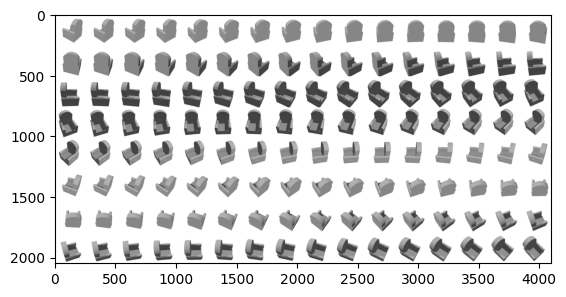

In [4]:
plt.imshow(rearrange(frames[:128], '(h1 w1) h w c -> (h1 h) (w1 w) c', h1=8, w1=16) )

In [5]:
model = Model(
    input_size=32,
    depth=12,
    hidden_size=768,
    num_heads=12,
    condition_channels=768,
    use_x_embedder=True,
    use_y_embedder=True,
    learn_sigma=False,
)
# (missing_keys, unexpected_keys) = model.load_state_dict(torch.load('../results/shapenet.checkpoint', map_location='cpu')['model'], strict=False)
model = model.to(device)

In [6]:
# print(missing_keys, unexpected_keys)

In [7]:
diffusion = create_diffusion(timestep_respacing="", predict_xstart=True, learn_sigma=False, sigma_small=True)  # default: 1000 steps, linear noise schedule
# diffusion = create_diffusion(timestep_respacing="")  # default: 1000 steps, linear noise schedule
vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-ema").to(device)

In [8]:
# nn.init.constant_(model.y_embedder.weight, 0)
# nn.init.constant_(model.y_embedder.bias, 0)

In [9]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0)
# number_warmup_epochs = 200
# def warmup(current_step: int):
#     return current_step / number_warmup_epochs
# warmup_scheduler = lr_scheduler.LambdaLR(opt, lr_lambda=warmup)
# train_scheduler = lr_scheduler.LambdaLR(opt, lambda current_step: 1)
# scheduler = lr_scheduler.SequentialLR(opt, [warmup_scheduler, train_scheduler], [number_warmup_epochs])

In [10]:
views = 32
iterations = 10000

pbar = range(iterations)
pbar = tqdm(pbar)

for i in pbar:

    x = video
    pos = grid

    n = torch.tensor(np.random.choice(np.arange(x.shape[2]), views))
    
    y = x[:,:, 0]
    x = x[:, :, n]
    
    pos = pos[:, :, n]

    y = y.to(torch.float32).to(device)
    x = x.to(torch.float32).to(device)
    pos = pos.to(torch.float32).to(device)

    # Map input images to latent space + normalize latents:
    x = rearrange(x, "N C T H W -> (N T) C H W")
    x = vae.encode(x).latent_dist.sample().mul_(0.18215)
    x = rearrange(x, "(N T) C H W -> N C T H W", T=len(n))
    y = vae.encode(y).latent_dist.sample().mul_(0.18215)

    t = torch.randint(0, diffusion.num_timesteps, (x.shape[0],), device=device)
    # t = torch.randint(0, diffusion.num_timesteps, (1,), device=device)
    # t = torch.cat([t] * x.shape[0])
    model_kwargs = dict(pos=pos, y=y)
    
    # noise = torch.randn(x.shape[0], x.shape[1], 1, *x.shape[3:], device=x.device)
    # noise = torch.cat(x.shape[2] * [noise], dim=2)

    loss_dict = diffusion.training_losses(model, x, t, model_kwargs)
    loss = loss_dict["loss"].mean()

    opt.zero_grad()
    loss.backward()
    opt.step()
    # scheduler.step()

    pbar.set_description("Loss %6f LR %6f" % (loss.item(), opt.param_groups[0]['lr']))

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss 0.002303 LR 0.000100:  20%|██        | 2019/10000 [45:38<3:00:24,  1.36s/it]


KeyboardInterrupt: 

In [11]:
x = video
pos = grid
latent_size = 32

eval_diffusion = create_diffusion(str(50), predict_xstart=True, learn_sigma=False, sigma_small=True)
# eval_diffusion = create_diffusion(str(50))

n = pos.shape[0]
z = torch.randn(n, 4, 1, latent_size, latent_size, device=device)
z = torch.cat(pos.shape[2] * [z], 2)

y = x[:, :, 0].to(torch.float32).to(device)
pos = pos.to(torch.float32).to(device)

with torch.no_grad():
    y = vae.encode(y).latent_dist.sample().mul_(0.18215)
model_kwargs = dict(pos=pos, y=y)

with torch.no_grad():
    with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
        samples = eval_diffusion.ddim_sample_loop(
            model, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=True, device=device
        )

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


In [12]:
T = samples.shape[2]
_samples = rearrange(samples, "N C T H W -> (N T) C H W")
with torch.no_grad():
    samples = []
    for frame in _samples:
        samples.append(vae.decode(frame.unsqueeze(0) / 0.18215).sample)
    samples = torch.cat(samples)
samples = torch.clamp(samples, -1, 1)
samples = samples.cpu()
samples = rearrange(samples, "(N T) C H W -> N T C H W", T=T)
for i, sample in enumerate(samples):
    pred_video = 255 * (sample.clip(-1, 1) / 2 + 0.5)
    torchvision.io.write_video(
        f"../samples/sample.mp4",
        pred_video.detach().permute(0, 2, 3, 1).numpy(),
        fps=18,
        video_codec="h264",
    )

In [ ]:
checkpoint = {
    "model": model.state_dict(),
    "opt": opt.state_dict(),
}
torch.save(checkpoint, "../results/shapenet.checkpoint")